<a href="https://colab.research.google.com/github/haroldeustaquio/Supermarket-Sales-Tracker-Mx/blob/revisiones/ML-models/asociation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Caso de Negocio

Una empresa distribuidora de bebidas está interesada en identificar los patrones de compra más comunes de sus consumidores, con el objetivo de mejorar la oferta de productos y aumentar las ventas. Para lograrlo, se analizarán las transacciones realizadas, se utilizarán técnicas de minería de datos para asociar diferentes características y descubrir insights relevantes.
Para este análisis, se han transformado algunas variables clave para facilitar la identificación de patrones, algunas columnas categorizadas son:

* `Temperatura` -> `Clima`
* `Fecha` -> `Estación`
* `Cantidad` -> `Categoría_Cantidad`

Estas transformaciones permitirán detectar relaciones más claras entre las condiciones climáticas, la estacionalidad y las cantidades de productos adquiridos.

### Preparación de Ambiente

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.frequent_patterns import fpgrowth

### Cargar Dataframe

In [3]:
df = pd.read_csv('Ventas_Bebidas_Demo.csv', encoding='latin-1')
df.columns = df.columns.str.lower()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Tamaño del dataset
print(df.shape)

# Información básica sobre los datos
print("\n")
df.info()
print("\n")
# Estadísticas descriptivas de los datos
df.describe()

In [ ]:
df.head()

In [ ]:
num_unique_products = df['producto_desc'].nunique()
print(f"Número de productos únicos: {num_unique_products}")

# Número total de pedidos
num_orders = df['pedido'].nunique()
print(f"Número total de pedidos: {num_orders}")

# Agrupar por PEDIDO y contar la cantidad de productos únicos
products_per_order = df.groupby('pedido')['producto_desc'].apply(lambda x: x.unique()).reset_index()
products_per_order['num_productos'] = products_per_order['producto_desc'].apply(len)

# Visualizar la distribución de productos por pedido
plt.figure(figsize=(10, 6))
sns.histplot(products_per_order['num_productos'], bins=range(0, products_per_order['num_productos'].max() + 10, 10), kde=True, color='skyblue')
plt.title('Distribución de la Cantidad de Productos por Pedido')
plt.xlabel('Número de Productos por Pedido (rangos de 10 en 10)')
plt.ylabel('Frecuencia')
plt.xticks(range(0, products_per_order['num_productos'].max() + 10, 10))  # Ajusta el rango de los ticks del eje x
plt.show()

# Verificar los productos más comunes
product_counts = df['producto_desc'].value_counts().reset_index()
product_counts.columns = ['producto_desc', 'frecuencia']

plt.figure(figsize=(12, 6))
sns.barplot(x='frecuencia', y='producto_desc', data=product_counts.head(20))
plt.title('Top 20 Productos Más Comunes')
plt.xlabel('Frecuencia')
plt.ylabel('Producto')
plt.show()

### Limpieza y Transformación de Datos

In [4]:
df['fecha'] = pd.to_datetime(df['fecha'], format='%d-%m-%y')

def obtener_estacion(fecha):
    mes = fecha.month
    dia = fecha.day

    # Invierno: 21 diciembre a 20 marzo
    if (mes == 12 and dia >= 21) or mes in [1, 2] or (mes == 3 and dia <= 20):
        return 'Invierno'
    # Primavera: 21 marzo a 20 junio
    elif (mes == 3 and dia >= 21) or mes in [4, 5] or (mes == 6 and dia <= 20):
        return 'Primavera'
    # Verano: 21 junio a 22 septiembre
    elif (mes == 6 and dia >= 21) or mes in [7, 8] or (mes == 9 and dia <= 22):
        return 'Verano'
    # Otoño: 23 septiembre a 20 diciembre
    elif (mes == 9 and dia >= 23) or mes in [10, 11] or (mes == 12 and dia <= 20):
        return 'Otoño'

def categorizar_temperatura(temp):
    if temp < 15:
        return 'Frío'
    elif 15 <= temp < 25:
        return 'Templado'
    elif 25 <= temp < 35:
        return 'Cálido'
    else:
        return 'Muy Cálido'

def categorizar_unidades(unidades):
    if unidades <= 50:
        return 'poco'
    elif 51 <= unidades <= 200:
        return 'moderado'
    else:
        return 'mucho'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
columns_to_drop = ['producto', 'producto_desc', 'monto' , 'precio_unidad', 'contador', 'segmento']
df.drop(columns=columns_to_drop,inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
df['estacion'] = df['fecha'].apply(obtener_estacion)
df.drop(columns=['fecha'], inplace=True)

df['clima'] = df['prom_temperatura'].apply(categorizar_temperatura)
df.drop(columns=['prom_temperatura'], inplace=True)

df['cat_unidades'] = df['unidades'].apply(categorizar_unidades)
df.drop(columns=['unidades'], inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
tienda_cat = defaultdict()
for i, tienda in enumerate(df['tienda'].unique(), start=1):
    tienda_cat[tienda] = f'Tienda {i}'

df['tienda'] = df['tienda'].replace(tienda_cat)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Selección de Variables

In [8]:
df['marca_municipio'] = df['marca'] +' - '+ df['municipio']
df['marca_estacion'] = df['marca'] +' - '+ df['estacion']
df['marca_clima'] = df['marca'] + ' - ' + df['clima']
df['marca_cat'] = df['marca'] + ' - ' + df['cat_unidades']

df.drop(columns=['estacion','clima','cat_unidades'],inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Aprori


### Situación 1: Análisis en los pedidos a través de marca + estación

In [40]:
basket = df.pivot_table(index=['pedido'], columns='marca_estacion', aggfunc='size', fill_value=0)
basket = (basket > 0).astype(bool)

frequent_itemsets = apriori(basket, min_support=0.2, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
def obtain_3_top_rules(rules, wordkeys):
    rules = rules.sort_values(by=['confidence','lift'],ascending=False)

    for i, item in enumerate(rules['antecedents'].values):
        for row in item:
            for clave in wordkeys:
                if clave in row:
                    rules.loc[i,'temp'] = clave

    result = pd.DataFrame(columns=rules.columns)
    groups = rules.groupby('temp')

    for name in groups.groups.keys():
        group = groups.get_group(name).head(3)  # Obtener los primeros 2
        result = pd.concat([result, group])      # Concatenar al resultado

    result.reset_index(drop=True, inplace=True)

    return(result.sort_values(by=['confidence','lift'],ascending=False).drop(columns='temp').reset_index(drop=True))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
obtain_3_top_rules(rules, ['Primavera', 'Invierno', 'Otoño', 'Verano'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-41-2854df4edda6>:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, group])      # Concatenar al resultado


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,"(JOYA - Primavera, COCA-COLA LIGHT - Primavera)",(COCA-COLA - Primavera),0.201033,0.275725,0.200636,0.998024,3.619634,0.145206,366.483115,0.905831
1,(JOYA - Primavera),(COCA-COLA - Primavera),0.239968,0.275725,0.235598,0.981788,3.560750,0.169433,39.769278,0.946224
2,(JOYA - Invierno),(COCA-COLA - Invierno),0.223679,0.263806,0.219309,0.980462,3.716600,0.160301,37.679741,0.941539
3,(COCA-COLA LIGHT - Primavera),(COCA-COLA - Primavera),0.234803,0.275725,0.229241,0.976311,3.540887,0.164500,30.574749,0.937778
4,(COCA-COLA LIGHT - Primavera),"(JOYA - Primavera, COCA-COLA - Primavera)",0.234803,0.235598,0.200636,0.854484,3.626874,0.145316,5.253042,0.946528
5,(JOYA - Primavera),"(COCA-COLA - Primavera, COCA-COLA LIGHT - Prim...",0.239968,0.229241,0.200636,0.836093,3.647219,0.145625,4.702407,0.954984


### Situación 2: Análisis en los pedidos a través de marca + clima

In [43]:
basket = df.pivot_table(index=['pedido'], columns='marca_clima', aggfunc='size', fill_value=0)
basket = (basket > 0).astype(bool)


frequent_itemsets = apriori(basket, min_support=0.45, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
obtain_3_top_rules(rules, ['Muy Cálido', 'Cálido', 'Templado', 'Frío'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-41-2854df4edda6>:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, group])      # Concatenar al resultado


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(JOYA - Cálido),(COCA-COLA - Cálido),0.490663,0.546683,0.481128,0.980567,1.793668,0.212891,23.326960,0.868744
1,(COCA-COLA LIGHT - Cálido),(COCA-COLA - Cálido),0.477155,0.546683,0.463647,0.971690,1.777431,0.202795,16.012772,0.836558
2,(COCA-COLA - Cálido),(JOYA - Cálido),0.546683,0.490663,0.481128,0.880087,1.793668,0.212891,4.247558,0.976100


### Situación 3: Análisis en los pedidos a través de marca + categoría

In [45]:
basket = df.pivot_table(index=['pedido'], columns='marca_cat', aggfunc='size', fill_value=0)
basket = (basket > 0).astype(bool)

frequent_itemsets = apriori(basket, min_support=0.60, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
obtain_3_top_rules(rules, ['poco', 'moderado', 'mucho'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-41-2854df4edda6>:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, group])      # Concatenar al resultado


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,"(SPRITE - poco, FANTA - poco)",(JOYA - poco),0.613826,0.811681,0.613429,0.999353,1.231214,0.115198,290.953516,0.486293
1,"(COCA-COLA - poco, FANTA - poco)",(JOYA - poco),0.613826,0.811681,0.611045,0.995469,1.226430,0.112814,41.564788,0.478088
2,(FANTA - poco),(JOYA - poco),0.627731,0.811681,0.624553,0.994937,1.225774,0.115036,37.193087,0.494774


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


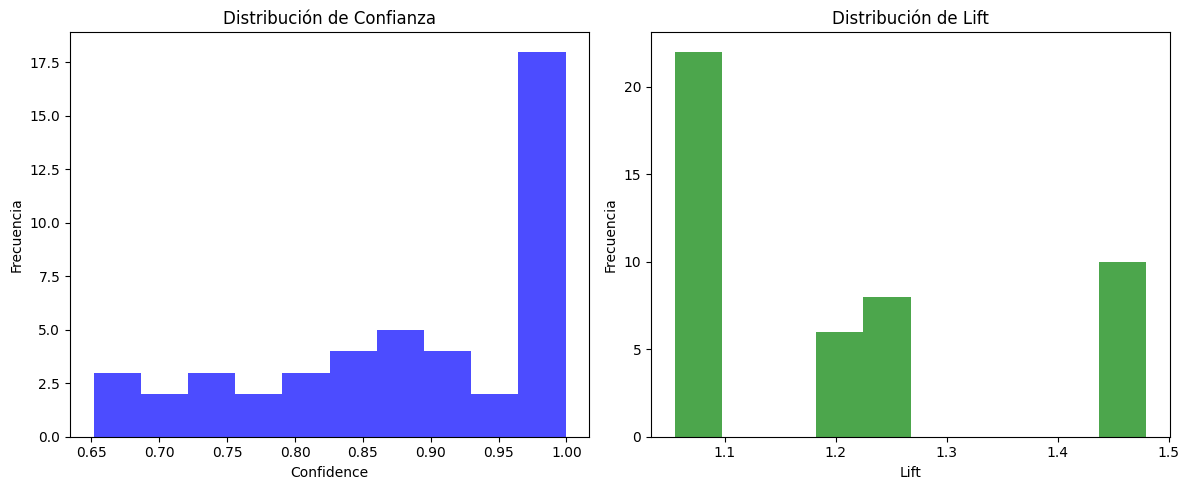

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de distribución de Confidence
ax1.hist(rules['confidence'], bins=10, color='blue', alpha=0.7)
ax1.set_title('Distribución de Confianza')
ax1.set_xlabel('Confidence')
ax1.set_ylabel('Frecuencia')

# Gráfico de distribución de Lift
ax2.hist(rules['lift'], bins=10, color='green', alpha=0.7)
ax2.set_title('Distribución de Lift')
ax2.set_xlabel('Lift')
ax2.set_ylabel('Frecuencia')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

La mayoría de las reglas tienen confianza alta, podemos decir que el algoritmo encontró asociaciones fuertes. El lift mayor a 1, indica que esas asociaciones son significativas y no aleatorias, sin embargo los valores obtenidos no supera por mucho a 1, así que pueden no ser tan significativas.

# FP-Growth

## Situación 1

In [48]:
# Crear la tabla de transacciones binaria
basket2 = df.pivot_table(index=['pedido'], columns='marca_estacion', aggfunc='size', fill_value=0)
basket2 = (basket2 > 0).astype(int)

# Aplicar el algoritmo FP-Growth
frequent_itemsets2 = fpgrowth(basket2, min_support=0.21, use_colnames=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [49]:
rules2 = association_rules(frequent_itemsets2, metric="confidence", min_threshold=0.5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
rules2[:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(JOYA - Invierno),(COCA-COLA - Invierno),0.223679,0.263806,0.219309,0.980462,3.716600,0.160301,37.679741,0.941539
1,(COCA-COLA - Invierno),(JOYA - Invierno),0.263806,0.223679,0.219309,0.831325,3.716600,0.160301,4.602475,0.992859
2,(JOYA - Primavera),(COCA-COLA - Primavera),0.239968,0.275725,0.235598,0.981788,3.560750,0.169433,39.769278,0.946224
3,(COCA-COLA - Primavera),(JOYA - Primavera),0.275725,0.239968,0.235598,0.854467,3.560750,0.169433,5.222397,0.992938
4,(COCA-COLA - Primavera),(COCA-COLA LIGHT - Primavera),0.275725,0.234803,0.229241,0.831412,3.540887,0.164500,4.538859,0.990763
5,(COCA-COLA LIGHT - Primavera),(COCA-COLA - Primavera),0.234803,0.275725,0.229241,0.976311,3.540887,0.164500,30.574749,0.937778


## Situación 2

In [51]:
basket2 = df.pivot_table(index=['pedido'], columns='marca_clima', aggfunc='size', fill_value=0)
basket2 = (basket2 > 0).astype(int)

# Aplicar el algoritmo
frequent_itemsets2 = fpgrowth(basket2, min_support=0.43, use_colnames=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [52]:
frequent_itemsets2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets
0,0.546683,(COCA-COLA - Cálido)
1,0.490663,(JOYA - Cálido)
2,0.477155,(COCA-COLA LIGHT - Cálido)
3,0.481128,"(COCA-COLA - Cálido, JOYA - Cálido)"
4,0.463647,"(COCA-COLA - Cálido, COCA-COLA LIGHT - Cálido)"


In [53]:
rules2 = association_rules(frequent_itemsets2, metric="confidence", min_threshold=0.5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
rules2[:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(COCA-COLA - Cálido),(JOYA - Cálido),0.546683,0.490663,0.481128,0.880087,1.793668,0.212891,4.247558,0.976100
1,(JOYA - Cálido),(COCA-COLA - Cálido),0.490663,0.546683,0.481128,0.980567,1.793668,0.212891,23.326960,0.868744
2,(COCA-COLA - Cálido),(COCA-COLA LIGHT - Cálido),0.546683,0.477155,0.463647,0.848110,1.777431,0.202795,3.442269,0.964865
3,(COCA-COLA LIGHT - Cálido),(COCA-COLA - Cálido),0.477155,0.546683,0.463647,0.971690,1.777431,0.202795,16.012772,0.836558


## Situación 3

In [55]:
basket2 = df.pivot_table(index=['pedido'], columns='marca_cat', aggfunc='size', fill_value=0)
basket2 = (basket2 > 0).astype(int)

# Aplicar el algoritmo
frequent_itemsets2 = fpgrowth(basket2, min_support=0.70, use_colnames=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [56]:
frequent_itemsets2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets
0,0.921335,(COCA-COLA - poco)
1,0.785856,(COCA-COLA LIGHT - poco)
2,0.811681,(JOYA - poco)
3,0.763607,"(COCA-COLA LIGHT - poco, COCA-COLA - poco)"
4,0.794597,"(JOYA - poco, COCA-COLA - poco)"


In [57]:
rules2 = association_rules(frequent_itemsets2, metric="confidence", min_threshold=0.5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
rules2[:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(COCA-COLA LIGHT - poco),(COCA-COLA - poco),0.785856,0.921335,0.763607,0.971689,1.054653,0.039571,2.778563,0.241991
1,(COCA-COLA - poco),(COCA-COLA LIGHT - poco),0.921335,0.785856,0.763607,0.828806,1.054653,0.039571,1.250880,0.658752
2,(JOYA - poco),(COCA-COLA - poco),0.811681,0.921335,0.794597,0.978953,1.062537,0.046767,3.737506,0.312535
3,(COCA-COLA - poco),(JOYA - poco),0.921335,0.811681,0.794597,0.862441,1.062537,0.046767,1.369005,0.748189


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


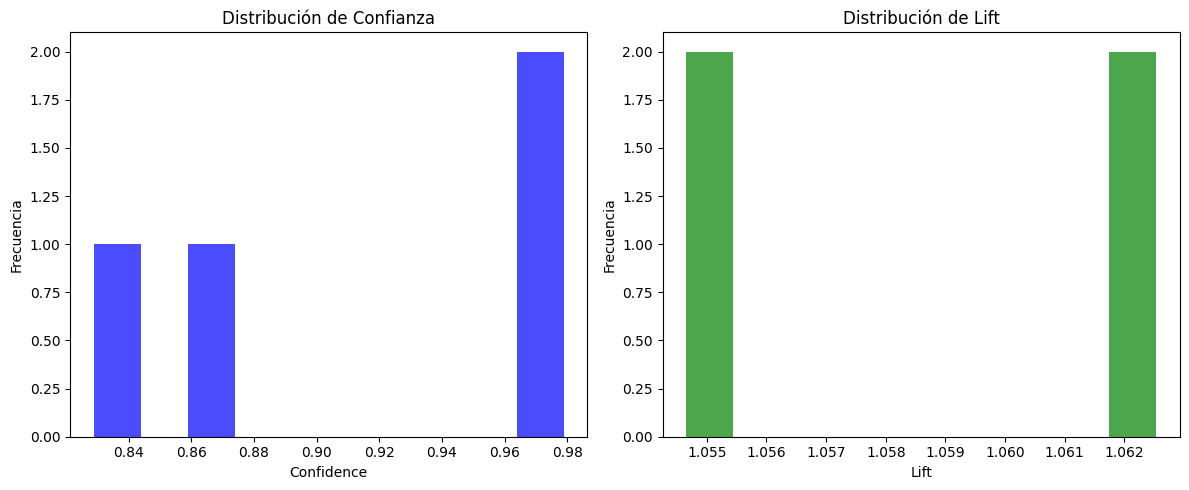

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de distribución de Confidence
ax1.hist(rules2['confidence'], bins=10, color='blue', alpha=0.7)
ax1.set_title('Distribución de Confianza')
ax1.set_xlabel('Confidence')
ax1.set_ylabel('Frecuencia')

# Gráfico de distribución de Lift
ax2.hist(rules2['lift'], bins=10, color='green', alpha=0.7)
ax2.set_title('Distribución de Lift')
ax2.set_xlabel('Lift')
ax2.set_ylabel('Frecuencia')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

Las reglas generadas tienen una confianza relativamente alta (más del 80%), lo que sugiere que los productos que aparecen juntos en las reglas suelen comprarse juntos con una buena probabilidad. Los valores de Lift apenas superan 1, las reglas tienen asociaciones algo más fuertes de lo que sería por pura casualidad, pero no lo suficiente para considerarlas muy significativas.

# Evaluación de resultados

Obtenemos resultados sino identicos muy similares, con ligeras variaciones que las primeras muestras solo se detectan con variaciones en el orden, pero no con el valor de cada atributo respecto a su renglon, por lo tanto ambos algoritmos nos dan resultados de confianza y no hay uno mejor que otro para este caso en particular.

# Conclusiones

Los resultados indican que los compradores tienen un consumo mayor en temporadas frías como son el invierno o temporadas cálidas en primavera para manejar la temperatura, por ende hay que enfocarnos más en las temporadas cálidas que se combate el calor con los liquidos, así como en el invierno por la cantidad de fiestas presentes que hacen que aumente el consumo. Algunos hallazgos:
* En primavera e invierno, las combinaciones de JOYA y COCA-COLA destacan, sugiriendo que promociones cruzadas pueden incrementar las ventas durante estas temporadas. Asimismo, en condiciones cálidas, JOYA y COCA-COLA muestran una alta confianza en su compra conjunta, lo que indica la efectividad de paquetes promocionales, así como COCA COLA en diferentes presentaciones. Finalmente, hay asociación entre SPRITE y FANTA con JOYA, asi como FANTA,COCA-COLA asociados con JOYA y FANTA y JOYA, todos en cantidades pequeñas.